# <center>Детекирование объектов на фотографиях с использованием YOLOv8

<center><img src='./img/CV_10_4_1.png'></img></center>

В [<b>другом ноутбуке</b>](./fcrnn.ipynb) используется модель *Faster R-CNN*

## <center>Подготовка датасета

In [35]:
from ultralytics import YOLO
from ultralytics.utils.ops import xyxy2xywh
import torch
import pickle
import shutil
import os
import time
import re
from data_classes.custom_dataset import CustomImageDataset
DATA_PATH = './data/VOC2012/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available accelerator: {DEVICE}\n')
if DEVICE == 'cuda':
    !nvidia-smi

Available accelerator: cuda

Fri Jan 26 21:07:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.40.06              Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   44C    P8             25W /  370W |    3277MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

Запишем в переменные путь к датасету

In [4]:
data_path_annotations = './data/VOC2012/Annotations/'
data_path_images = './data/VOC2012/JPEGImages/'
yolo_data_path = './datasets/yolo_data/'

Загрузим уже обученный энкодер для классов

In [4]:
with open('./model/label_encoder.pkl', 'rb') as encoder_file:
    label_encoder = pickle.load(encoder_file)

Создадим датафреймы для каждой выборки *train*, *valid*, *test*. Конвертируем координаты из формата $\{x_{min}, y_{min}, x_{max}, y_{max}\}$ в формат $\{x_{c}, y_{c}, w, h\}$

Для формирования и разделения выборок (в данном случае удобнее использовать именно датафреймы) используется [<b>собственный класс датасета</b>](./data_classes/custom_dataset.py)

In [4]:
train_df = CustomImageDataset(DATA_PATH, label_encoder, split='train').df.copy()
valid_df = CustomImageDataset(DATA_PATH, label_encoder, split='valid').df.copy()
test_df = CustomImageDataset(DATA_PATH, label_encoder, split='test').df.copy()

for df in [train_df, valid_df, test_df]:
    df[['xcenter', 'ycenter', 'box_width', 'box_height']] = xyxy2xywh(df[['xmin', 'ymin', 'xmax', 'ymax']].values)
    df['xcenter'] = df['xcenter'] / df['width']
    df['ycenter'] = df['ycenter'] / df['height']
    df['box_width'] = df['box_width'] / df['width']
    df['box_height'] = df['box_height'] / df['height']

train_df.head()

name  label  width  height   xmin   ymin   xmax   ymax  \
0  2008_007231.jpg     18    375     500    1.0  259.0  365.0  500.0   
1  2010_002860.jpg     17    500     375    1.0  141.0  500.0  373.0   
2  2008_003108.jpg     14    191     500   69.0   56.0  191.0  500.0   
3  2007_006673.jpg      3    500     333  294.0  110.0  324.0  196.0   
4  2012_001778.jpg     14    375     500  219.0  225.0  323.0  440.0   

    xcenter   ycenter  box_width  box_height  
0  0.488000  0.759000   0.970667    0.482000  
1  0.501000  0.685333   0.998000    0.618667  
2  0.680628  0.556000   0.638743    0.888000  
3  0.618000  0.459459   0.060000    0.258258  
4  0.722667  0.665000   0.277333    0.430000

Сделаем правильный формат датасета для модели *YOLO*.

In [5]:
for sample, df in [('train', train_df), ('val', valid_df), ('test', test_df)]:
    sample_path_imgs = os.path.join(yolo_data_path, 'images', sample)
    sample_path_labels = os.path.join(yolo_data_path, 'labels', sample)
    if not os.path.exists(sample_path_imgs):
        os.makedirs(sample_path_imgs)
    if not os.path.exists(sample_path_labels):
        os.makedirs(sample_path_labels)
    unique_images = df['name'].unique()
    for img in unique_images:
        img_df = df[df['name'] == img]
        labels_string = ''
        for row in img_df.iterrows():
            row_series = row[1]
            row_label = f'{row_series.label} {row_series.xcenter} {row_series.ycenter} {row_series.box_width} {row_series.box_height}\n'
            labels_string += row_label
        shutil.copy(os.path.join(data_path_images, img), os.path.join(yolo_data_path, 'images', sample))
        txt_name = re.sub(r'\.+[a-z]*', '.txt', img)
        with open(os.path.join(yolo_data_path, 'labels', sample, txt_name), 'w') as txt_label:
            txt_label.write(labels_string.rstrip('\n'))

Проверим, что датасет сформирован верно

In [9]:
!tree ./datasets -d

./datasets
└── yolo_data
    ├── images
    │   ├── test
    │   ├── train
    │   └── val
    └── labels
        ├── test
        ├── train
        └── val

9 directories


## <center>Обучение модели

Обучим (*fine-tuning*) модель средней сложности (с суффиксом `m`) на 40 эпохах, которая подойдет даже для **обработки видео**, если имеется достаточная вычислительная мощность

[<b>voc.yaml</b>](./voc.yaml) - файл, необходимый для изменения конфигурации модели: путь к выборкам, количество классов и их расшифровка

In [2]:
yolo = YOLO('yolov8m.pt')
results = yolo.train(model='yolov8m.pt', data='voc.yaml', epochs=40, imgsz=512, batch=8, pretrained=True, visualize=True)

New https://pypi.org/project/ultralytics/8.1.6 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.5 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=voc.yaml, epochs=40, time=None, patience=50, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=F

2024-01-26 16:32:08.180017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 16:32:08.180052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 16:32:08.214133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

train: Scanning /home/deep_learning/Object detection/datasets/yolo_data/labels/train.cache... 14070 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14070/14070 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/deep_learning/Object detection/datasets/yolo_data/labels/val.cache... 4772 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4772/4772 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      2.79G     0.9232      1.664      1.226         23        512: 100%|██████████| 1759/1759 [02:49<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:24<00:00, 12.39it/s]


                   all       4772       6021      0.276      0.488      0.276      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      2.87G       1.09      1.735      1.367         20        512: 100%|██████████| 1759/1759 [02:32<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:23<00:00, 12.93it/s]


                   all       4772       6021      0.273      0.393      0.239       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      2.88G      1.135      1.804      1.401         35        512: 100%|██████████| 1759/1759 [02:27<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.03it/s]


                   all       4772       6021      0.272      0.409      0.238      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      2.89G      1.124      1.774      1.398         28        512: 100%|██████████| 1759/1759 [02:28<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.75it/s]


                   all       4772       6021      0.301      0.397      0.254       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      2.89G      1.096      1.713      1.379         28        512: 100%|██████████| 1759/1759 [02:27<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.62it/s]


                   all       4772       6021       0.29       0.42      0.268      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      2.89G      1.056      1.616      1.355         21        512: 100%|██████████| 1759/1759 [02:33<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.57it/s]


                   all       4772       6021      0.321      0.463      0.299      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      2.88G      1.028      1.559      1.334         30        512: 100%|██████████| 1759/1759 [02:35<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:23<00:00, 12.89it/s]


                   all       4772       6021      0.306       0.48      0.311      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      2.89G      1.002      1.506      1.317         27        512: 100%|██████████| 1759/1759 [02:30<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.41it/s]


                   all       4772       6021      0.328      0.472      0.323      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      2.88G     0.9801      1.454      1.299         41        512: 100%|██████████| 1759/1759 [02:30<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:20<00:00, 14.33it/s]


                   all       4772       6021      0.326      0.504      0.322      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      2.88G     0.9661      1.422      1.291         26        512: 100%|██████████| 1759/1759 [02:24<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:20<00:00, 14.71it/s]


                   all       4772       6021      0.319       0.51      0.321      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      2.95G     0.9465      1.389      1.272         19        512: 100%|██████████| 1759/1759 [02:29<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:23<00:00, 12.58it/s]


                   all       4772       6021      0.328      0.516      0.338      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      2.87G      0.934      1.353      1.264         41        512: 100%|██████████| 1759/1759 [02:34<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:20<00:00, 14.35it/s]


                   all       4772       6021      0.325      0.513      0.335      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      2.93G     0.9209      1.324      1.255         23        512: 100%|██████████| 1759/1759 [02:33<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.76it/s]


                   all       4772       6021      0.331       0.52       0.34      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      2.93G     0.9026      1.292      1.246         32        512: 100%|██████████| 1759/1759 [02:33<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.79it/s]


                   all       4772       6021       0.34      0.543      0.347      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      2.87G     0.8838      1.262      1.232         18        512: 100%|██████████| 1759/1759 [02:32<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 14.18it/s]


                   all       4772       6021       0.35      0.515      0.347      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      2.87G     0.8809       1.24      1.228         22        512: 100%|██████████| 1759/1759 [02:34<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.41it/s]


                   all       4772       6021       0.32      0.574       0.35      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      2.88G     0.8696       1.22      1.221         22        512: 100%|██████████| 1759/1759 [02:33<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.99it/s]


                   all       4772       6021      0.322      0.572      0.344      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      2.89G     0.8516      1.186      1.207         27        512: 100%|██████████| 1759/1759 [02:34<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 14.09it/s]


                   all       4772       6021      0.331      0.557      0.355      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      2.84G     0.8444      1.169      1.201         13        512: 100%|██████████| 1759/1759 [02:32<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:20<00:00, 14.31it/s]


                   all       4772       6021      0.319      0.583      0.357      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      2.96G     0.8378      1.147      1.201         20        512: 100%|██████████| 1759/1759 [02:30<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.97it/s]


                   all       4772       6021       0.32       0.59      0.347       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      2.96G     0.8274      1.123      1.188         32        512: 100%|██████████| 1759/1759 [02:35<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.69it/s]


                   all       4772       6021      0.314      0.595      0.352      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      2.88G     0.8196      1.105      1.182         15        512: 100%|██████████| 1759/1759 [02:34<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.82it/s]


                   all       4772       6021      0.326      0.582      0.356      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      2.94G     0.8049      1.081      1.172         21        512: 100%|██████████| 1759/1759 [02:32<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.58it/s]


                   all       4772       6021      0.311      0.632      0.349      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      2.87G     0.7988      1.064      1.167         22        512: 100%|██████████| 1759/1759 [02:29<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:20<00:00, 14.62it/s]

                   all       4772       6021      0.317      0.588      0.351      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      2.88G     0.7815      1.034      1.153         20        512: 100%|██████████| 1759/1759 [02:28<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.74it/s]


                   all       4772       6021      0.317      0.599      0.355      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      2.87G       0.78      1.027      1.154         22        512: 100%|██████████| 1759/1759 [02:30<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.94it/s]


                   all       4772       6021      0.311      0.601      0.338      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      2.88G     0.7692      1.005      1.146         19        512: 100%|██████████| 1759/1759 [02:30<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 14.12it/s]


                   all       4772       6021       0.31      0.609      0.332      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      2.88G     0.7604     0.9918      1.141         21        512: 100%|██████████| 1759/1759 [02:28<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.73it/s]


                   all       4772       6021      0.305      0.622      0.342       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      2.84G     0.7526     0.9763      1.136         22        512: 100%|██████████| 1759/1759 [02:34<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.02it/s]


                   all       4772       6021      0.297      0.636      0.342       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      2.96G     0.7427     0.9535      1.129         38        512: 100%|██████████| 1759/1759 [02:35<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.26it/s]


                   all       4772       6021      0.295      0.639      0.341      0.272
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      2.86G     0.6658     0.7748       1.05          9        512: 100%|██████████| 1759/1759 [02:35<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.00it/s]


                   all       4772       6021       0.29      0.638      0.326      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      2.88G     0.6526     0.7479      1.043         14        512: 100%|██████████| 1759/1759 [02:34<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.09it/s]


                   all       4772       6021      0.292      0.621      0.326       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      2.87G     0.6383     0.7238      1.032         14        512: 100%|██████████| 1759/1759 [02:35<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.31it/s]

                   all       4772       6021      0.277      0.637      0.317      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      2.87G     0.6304     0.7054      1.026         23        512: 100%|██████████| 1759/1759 [02:34<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.55it/s]


                   all       4772       6021      0.278      0.641      0.313      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      2.88G     0.6196     0.6797      1.015          9        512: 100%|██████████| 1759/1759 [02:33<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 14.13it/s]


                   all       4772       6021      0.275      0.644      0.308      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      2.88G     0.6069     0.6569      1.007          9        512: 100%|██████████| 1759/1759 [02:34<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.22it/s]


                   all       4772       6021      0.271      0.655      0.301       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      2.88G     0.5988     0.6352      1.002         13        512: 100%|██████████| 1759/1759 [02:30<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:23<00:00, 12.68it/s]


                   all       4772       6021      0.268      0.639      0.294      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      2.87G     0.5897     0.6224     0.9966         21        512: 100%|██████████| 1759/1759 [02:32<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.99it/s]


                   all       4772       6021      0.263      0.651      0.289      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      2.86G     0.5784     0.6044     0.9883         11        512: 100%|██████████| 1759/1759 [02:32<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.98it/s]


                   all       4772       6021      0.264      0.621      0.285      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      2.87G     0.5743     0.5851     0.9846          9        512: 100%|██████████| 1759/1759 [02:33<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:21<00:00, 13.66it/s]


                   all       4772       6021      0.258      0.634      0.278      0.219

40 epochs completed in 1.950 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.5 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)
Model summary (fused): 218 layers, 25851340 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 299/299 [00:22<00:00, 13.49it/s]


                   all       4772       6021      0.318      0.597      0.355      0.281
             aeroplane       4772        155      0.466      0.754      0.535      0.457
               bicycle       4772        127      0.339      0.496      0.424      0.342
                  bird       4772        192      0.363      0.693      0.514      0.384
                  boat       4772        157      0.246      0.401      0.233      0.155
                bottle       4772        236      0.203      0.521      0.156       0.11
                   bus       4772         96      0.319      0.771      0.305      0.263
                   car       4772        370       0.25      0.508      0.279      0.215
                   cat       4772        192      0.622      0.806      0.695       0.58
                 chair       4772        501       0.19      0.395      0.155      0.102
                   cow       4772        122       0.29      0.672      0.339      0.261
           diningtabl

Отобразим, как менялись целевые метрики и функции потерь в зависимости от эпохи

<img src="img/results.png" alt="drawing" width="1280"/>

Видно, что **переобучение** началось примерно с 20й эпохи

Загрузим лучшую модель (не последнюю) на основе показателей метрик/функции потерь **валидационной выборки**

In [2]:
best_model_path = './runs/detect/train/weights/best.pt'
best_yolo = YOLO(best_model_path)

## <center>Оценка качества

Сделаем валидацию на **тестовой выборке** и отобразим графики

In [18]:
test_metrics = best_yolo.val(split='test')

Ultralytics YOLOv8.1.5 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12288MiB)


val: Scanning /home/deep_learning/Object detection/datasets/yolo_data/labels/test... 4833 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4833/4833 [00:02<00:00, 2026.12it/s]

val: New cache created: /home/deep_learning/Object detection/datasets/yolo_data/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 303/303 [00:28<00:00, 10.76it/s]


                   all       4833       6021      0.302      0.606      0.339      0.263
             aeroplane       4833        146      0.493      0.781      0.573      0.442
               bicycle       4833        124      0.261      0.468      0.341      0.276
                  bird       4833        189      0.368      0.704      0.495      0.368
                  boat       4833        161      0.242      0.477      0.209      0.149
                bottle       4833        232      0.171      0.444      0.148      0.103
                   bus       4833        110      0.288        0.7       0.28       0.23
                   car       4833        378      0.263      0.545      0.274      0.206
                   cat       4833        191        0.6      0.796      0.708      0.591
                 chair       4833        416      0.164      0.411      0.131     0.0858
                   cow       4833        109      0.268      0.651      0.291      0.231
           diningtabl

<img src="img/confusion_matrix_normalized.png" alt="drawing" width="1280"/>

По матрице ошибок видно, что модель почти не путается между классами (малое количество *FP* и *FN*)

<img src="img/F1_curve.png" alt="drawing" width="1280"/>

Наибольшее значение $F_1$-score находится около уровня уверенности $\approx 0.35$

<img src="img/PR_curve.png" alt="drawing" width="1280"/>

$\text{mAP@50} \approx 0.339$ 

Сравнение c *Faster R-CNN* находится в [<b>readme файле</b>](./README.md)

Отобразим несколько тестовых примеров

In [17]:
test_path = os.path.join(yolo_data_path, 'images', 'test')
test_images = [os.path.join(test_path, test_img) for test_img in os.listdir(test_path)]
test_preds = best_yolo.predict(test_images[:10], save=True, conf=0.5)


0: 512x512 1 person, 1: 512x512 3 persons, 2: 512x512 1 aeroplane, 2 persons, 3: 512x512 1 train, 4: 512x512 1 cow, 5: 512x512 1 boat, 6: 512x512 5 persons, 7: 512x512 3 aeroplanes, 8: 512x512 1 person, 9: 512x512 2 cars, 1 dog, 266.9ms
Speed: 1.4ms preprocess, 26.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict


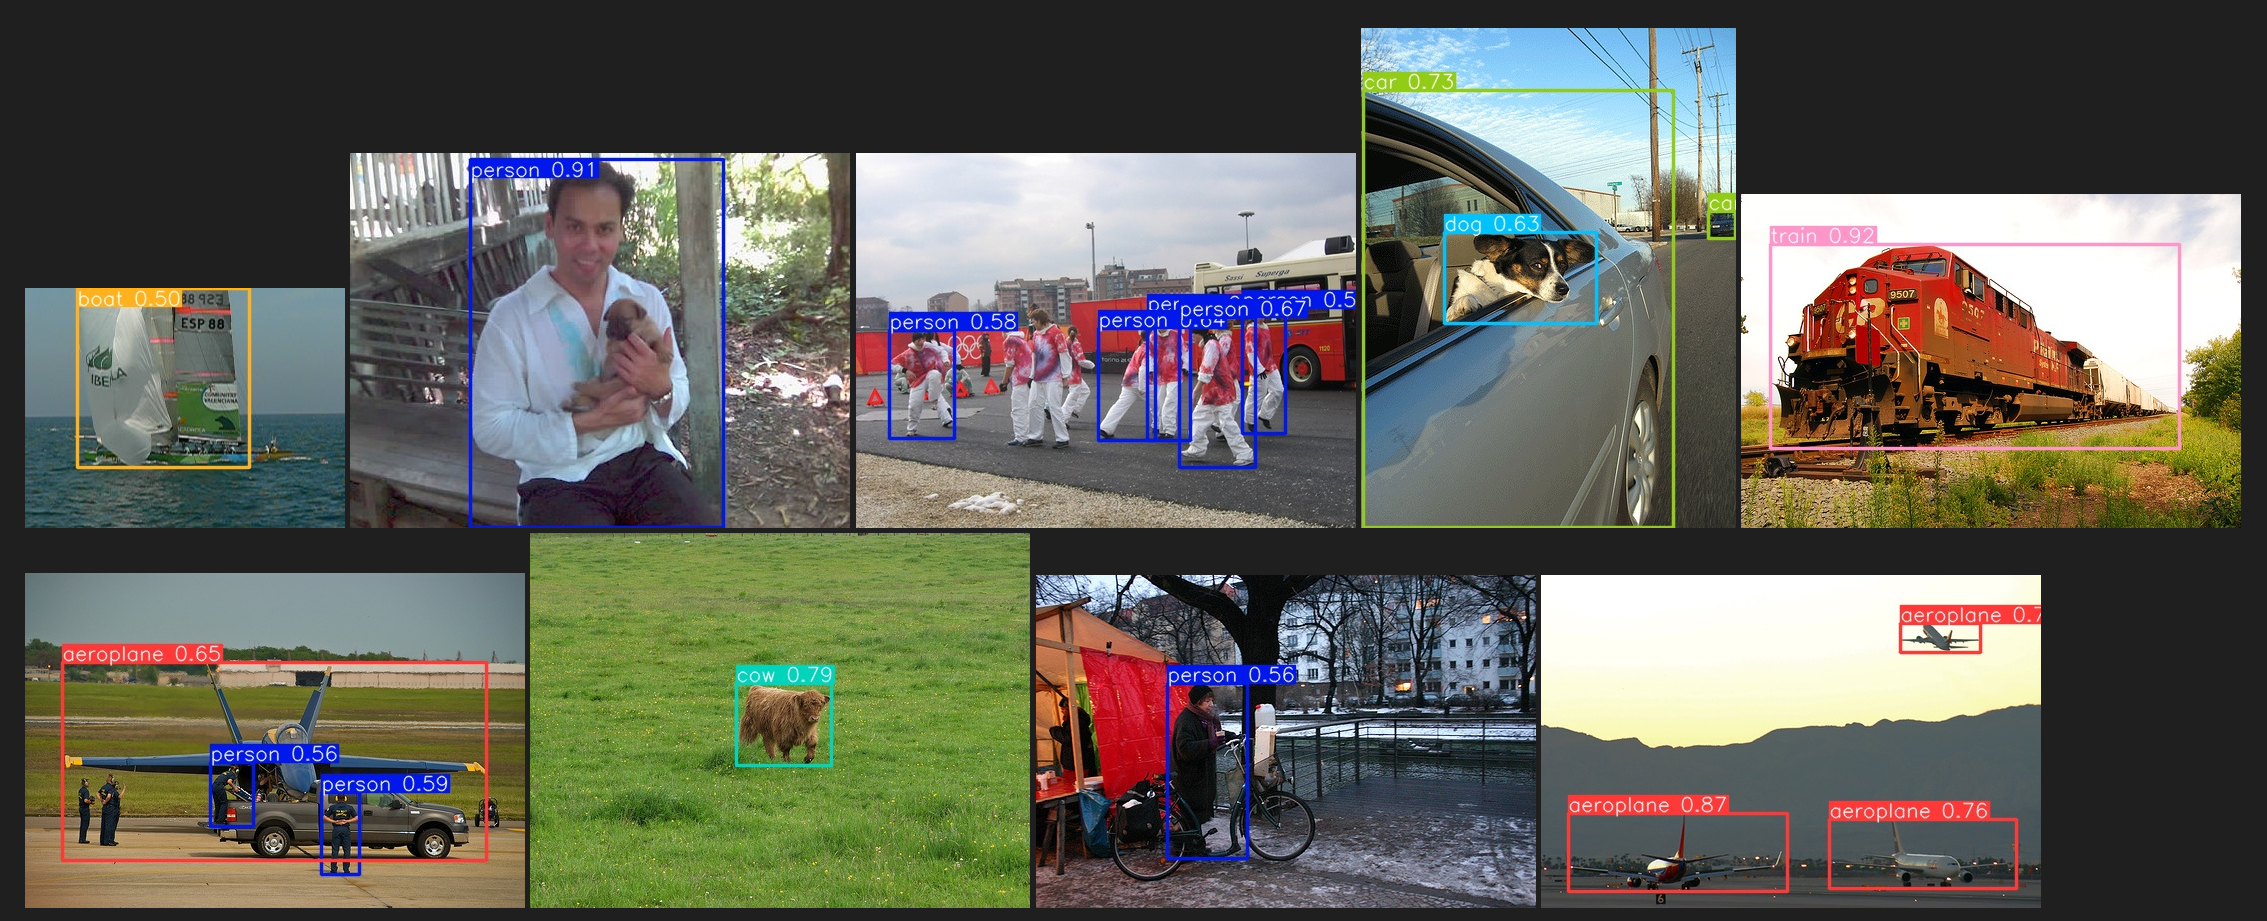

Замерим, сколько времени необходимо сети для обработки одного изображения, чтобы сравнить результаты с *Faster R-CNN*. Результаты сравнения будут в [<b>readme файле</b>](./README.md)

In [41]:
start_time = time.time()
one_pred_time = best_yolo.predict('./data/VOC2012/JPEGImages/2007_000027.jpg')
end_time = time.time()
total_time = end_time - start_time
print(f'{total_time:.5f} seconds')


image 1/1 /home/deep_learning/Object detection/data/VOC2012/JPEGImages/2007_000027.jpg: 512x512 1 person, 52.9ms
Speed: 2.2ms preprocess, 52.9ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)
0.06300 seconds
